# REINFORCE in Python

### 패키지 import
의존성 있는 패키지인 ``` numpy ```, ``` tensorflow ```, ``` keras ```를 import해야 한다.  
  
참고: keras는 단독으로 import하지 않고 반드시 ``` import tensorflow.keras as keras ```와 같이 ``` tensorflow ```를 통해 import해야 잠재적인 오류를 예방할 수 있다.  

주어진 모듈을 설치하기 위해서는 `pip install numpy`, `pip install tensorflow`를 실행하자.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

## Policy Gradient - REINFORCE
### Model Building
REINFORCE는 Monte-Carlo 방식으로 policy-based learning을 진행하는 on-policy 강화학습법이다.  
  
먼저 늘 그렇듯 Policy Gradient(PG)를 위한 neural network를 정의하여야 한다. 기존에 작성하였던 방식은 `keras.Sequential`을 이용한 순차지향적 방식이었으나, 이번에는 조금 다르게 객체지향적 방식으로 `keras.Model` 클래스를 상속해 코드를 작성해 보겠다.

객체지향 방식은 간단하다. `keras.Model` 클래스를 상속한 후 `call(self, inputs)` 메서드를 구현해 주면 된다. 이때 neural net을 함수처럼 쌓아 주는 식으로 구현하면 편하다. 아래의 클래스 생성자에서 각각의 파라미터는 다음을 뜻한다.

* ``` l_rate ```는 학습률을 나타낸다.
* ``` n_actions ```는 tabular action의 개수를 나타낸다.
* ``` input_dims ```는 state의 feature dimension이다.

In [2]:
class ReinforceNetwork(keras.Model):
    def __init__(self, l_rate, n_actions, input_dims):
        super(ReinforceNetwork, self).__init__() # 상위 클래스의 생성자 호출
        self.l_rate     = l_rate
        self.n_actions  = n_actions
        self.input_dims = input_dims

        self.layer1 = keras.layers.Dense(64, activation='relu')
        self.layer2 = keras.layers.Dense(64, activation='relu')
        self.layer3 = keras.layers.Dense(n_actions, activation='softmax') # 확률이 출력이므로 activation = 'softmax'

        self.compile(optimizer=keras.optimizers.Adam(learning_rate=l_rate))

    def call(self, inputs):
        mid1 = self.layer1(inputs)
        mid2 = self.layer2(mid1)
        return self.layer3(mid2)

위의 `ReinforceNetwork` 클래스를 활용해 REINFORCE 강화학습을 진행하는 `EpisodicReinforceAgent` 클래스를 정의한다. 이 코드에서 PG는 **episodic reward**를 reward function으로 설정하였다. 정책 $\pi_\theta$에서 reward function $J(\theta)$는 다음과 같이 정의된다.

$$ J(\theta) = \mathbb{E}_{S_0 \sim d_0, \pi_\theta}\left[ \sum_{t=0}^{\infty}{\gamma^t R_{t+1}} \right] = \mathbb{E}_{S_0 \sim d_0, \pi_\theta}\left[ G_0 \right] = \mathbb{E}_{S_0 \sim d_0}\left[ v_{\pi_\theta} (S_0) \right] $$

Policy Gradient Theorem(episodic)에 의하여, 위 식의 그래디언트인 $\nabla_\theta J(\theta)$ 는 다음과 같다.

$$ \nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \left. \sum_{t=0}^{T}{\gamma^t q_{\pi_\theta}(S_t, A_t) \nabla_\theta \log \pi_\theta (A_t \mid S_t)} \right| S_0 \sim d_0 \right]$$

이때 $q_{\pi_\theta}(S_t, A_t) = \mathbb{E}_{\pi_\theta}\left[ \left. G_t \right| S_t, A_t \right]$ 이므로 지금과 같은 stochastic 조건 하에서 $q_{\pi_\theta}(S_t, A_t) \approx G_t$ 로 간주할 수 있다. 또한 일반적으로 $\gamma^t$ 항은 생략한다. 따라서 업데이트는 다음과 같이 이루어진다.

$$ t \in \{ 0, 1, ..., N \}: \theta \leftarrow \theta + \alpha G_t \nabla_\theta \log \pi_\theta (A_t \mid S_t) $$

In [3]:
def categoricalSelect(L):
    ''' L[i] 확률로 i를 반환하는 함수. 어떠한 i에도 해당하지 않으면 0 반환. 0 <= sum(L) <= 1인 경우에만 정의됨.'''
    L = list(tf.squeeze(L))
    pick = np.random.random()
    cumul = 0

    for i, pi in enumerate(L):
        if (cumul <= pick < cumul + float(pi)):
            return i
        cumul += pi

    return 0

class ReinforceAgent:
    def __init__(self, input_dims, l_rate, gamma, n_actions, filename):
        # PG 특성상 epsilon은 사용하지 아니함
        self.read_only = False
    
        self.gamma = gamma
        self.action = [i for i in range(n_actions)]

        self.policy = ReinforceNetwork(l_rate, n_actions, input_dims)

        # 하나의 episode에 대하여만 행동을 기록하는 배열
        self.state, self.action, self.reward = \
            list(), list(), list()

        # model 저장용
        self.filename = filename
    
    def choose_action(self, obs):
        ''' 내부 stochastic policy인 `self.policy`를 토대로 action 결정 '''
        state = np.array([obs], dtype=np.float32) # 관찰 결과를 numpy 스타일로 변환 (tf.convert_to_tensor도 ok)
        pr = self.policy(state) # 신경망으로 전달, 확률 pr에 저장
        return categoricalSelect(pr)

    def store(self, state, action, reward):
        ''' 데이터 저장. 여기서 state는 엄밀하게는 observation을 뜻함. '''
        if self.read_only:
            raise Exception("ReinforceDeploy class can only use model, not store.")
            return

        self.state.append(state)
        self.action.append(action)
        self.reward.append(reward)

    def learn(self):
        ''' Monte-Carlo 방식으로 강화학습 진행. 이후 episode는 폐기 '''
        # 잡지식 하나: np.array와 tf.Tensor의 차이점은?
        # 정답: 내부구조는 거의 완벽히 동일해서 변환은 constant time 안에 가능.
        # 다만 tf.Tensor는 GPU에도 저장할 수 있음
        if self.read_only:
            raise Exception("ReinforceDeploy class can only use model, not learn.")
            return

        reward = tf.convert_to_tensor(self.reward, dtype=np.float32)
        
        G = np.zeros(reward.shape) # G value (미래누적보상) 저장
        for t in reversed(range(len(reward))): # G값 계산하는 코드
            if t == len(reward)-1:
                # 종료 케이스. 미래보상 없음
                G[t] = reward[t]
            else:
                # 미래보상 할인율 gamma 적용
                G[t] = reward[t] + self.gamma * G[t+1]

        # 입력에 따른 self.policy의 그래디언트 기록
        # *** 상당히 어려운 부분임: https://www.tensorflow.org/guide/autodiff 읽어볼것
        with tf.GradientTape() as tape:
            Loss = 0
            for t, (gt, st) in enumerate(zip(G, self.state)):
                state = tf.convert_to_tensor([st], dtype=tf.float32) # 텐서화
                Pr = tf.squeeze(self.policy(state)) # 신경망 투입으로 학습가능 파라미터의 gradient 기록
                LogPr = tf.math.log(Pr[self.action[t]]) # 그 당시 골랐던 action에 log끼움
                Loss -= gt * LogPr # Gradient Ascent이므로 Loss에서 "빼" 줌
 
        # 기록은 종료됨. 기록된 그래디언트 적용해 경사하강
        grad = tape.gradient(Loss, self.policy.trainable_variables)
        self.policy.optimizer.apply_gradients(zip(grad, self.policy.trainable_variables))
        
        # episode learning 끝. 배열 초기화
        self.state, self.action, self.reward = \
            list(), list(), list()

    def save_model(self):
        if self.read_only:
            raise Exception("ReinforceDeploy class can only use model, not save.")
            return

        self.policy.save(self.filename)
    
    def load_model(self):
        self.policy = keras.models.load_model(self.filename)

class ReinforceDeploy(ReinforceAgent):
    ''' Model의 학습과 저장은 불가능하고 오직 사용만을 위한 class '''
    def __init__(self, filename):
        self.filename = filename
        self.read_only = True
        self.load_model()

## Model Evaluating

### Gym을 사용한 가상환경 준비
OpenAI에서 제공하는 gym 모듈을 사용해 보자. 이 모듈은 `pip install gym`을 통해 설치할 수 있다.

In [4]:
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

env = gym.make('CartPole-v1')
observation = env.reset()

### Agent 학습
아래의 코드 블록을 실행하면 랜덤하게 초기화된 cartAgent가 강화학습을 시작한다.

score 22.0 | recent average score 22.0:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 69.0 | recent average score 27.3:   5%|▍         | 49/1000 [00:03<01:04, 14.72it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 20.0 | recent average score 32.0:  10%|▉         | 99/1000 [00:07<01:29, 10.03it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 52.0 | recent average score 37.5:  15%|█▌        | 150/1000 [00:12<01:41,  8.34it/s] 

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 39.0 | recent average score 40.4:  20%|█▉        | 199/1000 [00:17<01:25,  9.40it/s] 

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 44.0 | recent average score 45.6:  25%|██▌       | 250/1000 [00:23<01:36,  7.74it/s] 

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 158.0 | recent average score 72.5:  30%|███       | 300/1000 [00:31<02:09,  5.42it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 88.0 | recent average score 118.8:  35%|███▌      | 350/1000 [00:44<02:38,  4.11it/s] 

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 108.0 | recent average score 156.0:  40%|████      | 400/1000 [01:03<04:21,  2.29it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 80.0 | recent average score 209.2:  45%|████▌     | 450/1000 [01:27<04:55,  1.86it/s] 

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 106.0 | recent average score 241.8:  50%|█████     | 500/1000 [01:55<06:10,  1.35it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 131.0 | recent average score 246.9:  55%|█████▌    | 550/1000 [02:27<04:36,  1.63it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 187.0 | recent average score 302.8:  60%|██████    | 600/1000 [03:05<05:35,  1.19it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 146.0 | recent average score 279.4:  65%|██████▌   | 650/1000 [03:43<02:50,  2.05it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 200.0 | recent average score 186.8:  70%|███████   | 700/1000 [04:06<02:37,  1.91it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 379.0 | recent average score 286.8:  75%|███████▌  | 750/1000 [04:40<02:52,  1.45it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 215.0 | recent average score 354.8:  80%|████████  | 800/1000 [05:23<03:15,  1.03it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 500.0 | recent average score 385.7:  85%|████████▌ | 850/1000 [06:10<02:09,  1.16it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 395.0 | recent average score 351.6:  90%|█████████ | 900/1000 [06:55<01:31,  1.10it/s]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 318.0 | recent average score 396.4:  95%|█████████▌| 950/1000 [07:43<00:53,  1.07s/it]

INFO:tensorflow:Assets written to: cartpole-reinforce\assets


score 490.0 | recent average score 264.9: 100%|██████████| 1000/1000 [08:18<00:00,  2.01it/s]


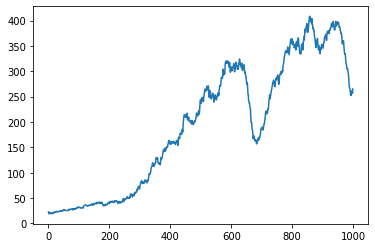

In [6]:
cartAgent = ReinforceAgent(
    input_dims=env.observation_space.shape, 
    l_rate=0.0003, 
    gamma=0.98,
    n_actions=env.action_space.n, 
    filename='cartpole-reinforce'
)

scores, scores_avg = list(), list()
prgress = tqdm(range(1000))

for episode in prgress:
    # 환경 및 점수 초기화
    score = 0
    obs_this = env.reset()
    done = False

    while not done:
        # Agent가 선택
        action = cartAgent.choose_action(obs_this)
        obs_next, reward, done, info = env.step(action)
        cartAgent.store(obs_this, action, reward)
        
        # 보상 저장
        score += reward
        obs_this = obs_next
        # env.render() # 렉 걸릴 경우 제외

    # Agent 학습
    cartAgent.learn()

    scores.append(score) # 점수 기록
    scores_avg.append(np.mean(scores[-30:]))  # 이동평균 산출
    prgress.set_description("score {:>3.1f} | recent average score {:>3.1f}".format(scores[-1], scores_avg[-1]))

    if episode % 50 == 0: # 50 episode마다 모델을 저장
        cartAgent.save_model()

plt.plot(np.arange(len(scores)), np.array(scores_avg)) # 이동평균 점수 그래프 그리기

다음은 학습한 모델을 불러와 실행하는 블록이다.

score 338.0 | recent average score 335.9: 100%|██████████| 50/50 [02:02<00:00,  2.44s/it]


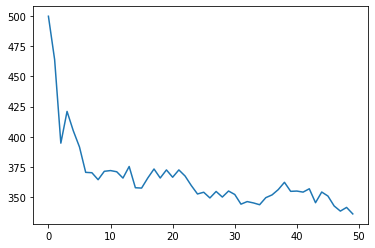

In [8]:
cartDeploy = ReinforceDeploy('cartpole-reinforce')

scores, scores_avg = list(), list()
prgress = tqdm(range(50))

for episode in prgress:
    # 환경 및 점수 초기화
    score = 0
    obs_this = env.reset()
    done = False

    while not done:
        # Agent가 선택
        action = cartDeploy.choose_action(obs_this)
        obs_next, reward, done, info = env.step(action)
        
        # 보상 저장
        score += reward
        obs_this = obs_next
        env.render()

    scores.append(score) # 점수 기록
    scores_avg.append(np.mean(scores[-30:]))  # 이동평균 산출
    prgress.set_description("score {:>3.1f} | recent average score {:>3.1f}".format(scores[-1], scores_avg[-1]))

plt.plot(np.arange(len(scores)), np.array(scores_avg)) # 이동평균 점수 그래프 그리기

### 참고: Gradient Tape
Tensorflow는 복잡한 함수의 gradient를 직접 구하지 않아도 gradient를 자동으로 계산해 주고 반영할 수 있게 해 준다. 아래의 예제들을 통해 이해하여 보자.

In [ ]:
x = tf.Variable(3.0)
y = tf.Variable(2.0)
with tf.GradientTape() as tape:
    Loss = tf.math.log(x) + y
    print(type(Loss))

grad = tape.gradient(Loss, x)
print("Grad: {}".format(grad))

In [ ]:
W = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape() as tape:
  y = x @ W + b
  Loss = tf.reduce_mean(y**2)

# 만약 tape.gradient(Loss, W); tape.gradient(Loss, b)와 같이 두 번에 걸쳐 계산하려면
# .gradient를 두 번 호출한다. 이 경우 with절에서 tf.GradientTape(persistent=True)를 사용해야 한다.
gW, gb = tape.gradient(Loss, [W, b]) 
assert W.shape == gW.shape and b.shape == gb.shape
print("gW\n{}\n*********\ngb\n{}".format(gW, gb))

In [ ]:
import tensorflow_probability as tfp

Qs = tfp.distributions.Categorical(probs=[0.1, 0.5, 0.4])
L = [Qs.sample() for i in range(100)]
Pr = [L.count(i) / len(L) for i in [0, 1, 2]]
print(Pr)
print(Qs.prob(0))
print(tf(Qs.prob(0)))
print(Qs.log_prob(0))
print(type(Qs.log_prob(0)))
print(type())
